# Website A/B Testing - Lab

## Introduction

In this lab, you'll get another chance to practice your skills at conducting a full A/B test analysis. It will also be a chance to practice your data exploration and processing skills! The scenario you'll be investigating is data collected from the homepage of a music app page for audacity.

## Objectives

You will be able to:
* Analyze the data from a website A/B test to draw relevant conclusions
* Explore and analyze web action data

## Exploratory Analysis

Start by loading in the dataset stored in the file 'homepage_actions.csv'. Then conduct an exploratory analysis to get familiar with the data.

> Hints:
    * Start investigating the id column:
        * How many viewers also clicked?
        * Are there any anomalies with the data; did anyone click who didn't view?
        * Is there any overlap between the control and experiment groups? 
            * If so, how do you plan to account for this in your experimental design?

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

In [5]:
df = pd.read_csv('homepage_actions.csv')
df.head(10)

,timestamp,id,group,action
0,2016-09-24 17:42:27.839496,804196,experiment,view
1,2016-09-24 19:19:03.542569,434745,experiment,view
2,2016-09-24 19:36:00.944135,507599,experiment,view
3,2016-09-24 19:59:02.646620,671993,control,view
4,2016-09-24 20:26:14.466886,536734,experiment,view
5,2016-09-24 20:32:25.712659,681598,experiment,view
6,2016-09-24 20:39:03.248853,522116,experiment,view
7,2016-09-24 20:57:20.336757,349125,experiment,view
8,2016-09-24 20:58:01.948663,349125,experiment,click
9,2016-09-24 21:00:12.278374,560027,control,view


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8188 entries, 0 to 8187
Data columns (total 4 columns):
timestamp    8188 non-null object
id           8188 non-null int64
group        8188 non-null object
action       8188 non-null object
dtypes: int64(1), object(3)
memory usage: 256.0+ KB


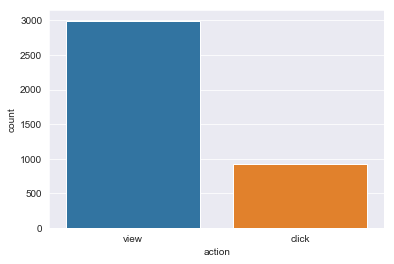

In [9]:
experiment = df[df.group == 'experiment']
sns.countplot(experiment.action);

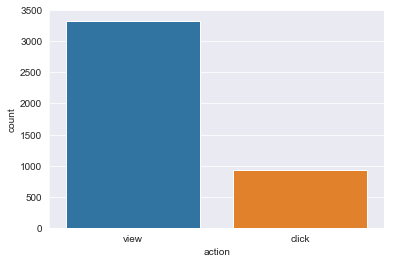

In [10]:
control = df[df.group == 'control']
sns.countplot(control.action);

In [14]:
cids = set(df[df.action == 'click']['id'].unique())
eids = set(df[df.action == 'view']['id'].unique())
print("Number of Viewers: {} \tNumber of Clickers: {}".format(len(vids), len(cids)))
print("Number of Viewers who didn't click: {}".format(len(vids-cids)))
print("Number of Clickers who didn't view: {}".format(len(cids-vids)))

Number of Viewers: 6328 	Number of Clickers: 1860
Number of Viewers who didn't click: 4468
Number of Clickers who didn't view: 0


In [15]:
#We can see here that we do not ahve anyone who clicked without first viewing!

In [18]:
eids = set(df[df.group == 'experiment']['id'].unique())
cids = set(df[df.group == 'control']['id'].unique())
print("Number of overlapping id's between groups: {}".format(len(eids&cids)))

Number of overlapping id's between groups: 0


## Conduct a Statistical Test

Conduct a statistical test to determine whether the experimental homepage was more effective than that of the control group.

In [20]:
df['count'] = 1
df.head()

,timestamp,id,group,action,count
0,2016-09-24 17:42:27.839496,804196,experiment,view,1
1,2016-09-24 19:19:03.542569,434745,experiment,view,1
2,2016-09-24 19:36:00.944135,507599,experiment,view,1
3,2016-09-24 19:59:02.646620,671993,control,view,1
4,2016-09-24 20:26:14.466886,536734,experiment,view,1


In [30]:
control = df[df.group == 'control'].pivot(index='id', columns='action', values='count')
control = control.fillna(value=0)

experiment = df[df.group == 'experiment'].pivot(index='id', columns='action', values='count')
experiment = experiment.fillna(value=0)

print("Sample sizes:\tControl: {}\tExperiment: {}".format(
    len(control), len(experiment))
     )
print("Total clicks:\tControl: {}\tExperiment: {}".format(
    sum(control.click), sum(experiment.click))
     )
print("Average click rate:\tControl: {}\tExperiment: {}".format(control.click.mean(), experiment.click.mean()))
control.head()

Sample sizes:	Control: 3332	Experiment: 2996
Total clicks:	Control: 932.0	Experiment: 928.0
Average click rate:	Control: 0.2797118847539016	Experiment: 0.3097463284379172


action,click,view
id,,
182994,1.0,1.0
183089,0.0,1.0
183248,1.0,1.0
183515,0.0,1.0
183524,0.0,1.0


## Verifying Results

One sensible formulation of the data to answer the hypothesis test above would be to create a binary variable representing each individual in the experiment and control group. This binary variable would represent whether or not that individual clicked on the homepage; 1 for they did and 0 if they did not. 

The variance for the number of successes in a sample of a binomial variable with n observations is given by:

## $n\bullet p (1-p)$

Given this, perform 3 steps to verify the results of your statistical test:
1. Calculate the expected number of clicks for the experiment group, if it had the same click-through rate as that of the control group. 
2. Calculate the number of standard deviations that the actual number of clicks was from this estimate. 
3. Finally, calculate a p-value using the normal distribution based on this z-score.

### Step 1:
Calculate the expected number of clicks for the experiment group, if it had the same click-through rate as that of the control group. 

In [32]:
control_click_rate = control.click.mean()
experimental_expected_clicks_given_null = control_click_rate * len(experiment)
print(experimental_expected_clicks_given_null)

838.0168067226891


### Step 2:
Calculate the number of standard deviations that the actual number of clicks was from this estimate.

In [35]:
n = len(experiment)
p = control_click_rate
var = n * p * (1 - p)
std = np.sqrt(var)
print(std)

24.568547907005815


In [37]:
real_experiment_clicks = experiment.click.sum()
z_score = (real_experiment_clicks - experimental_expected_clicks_given_null) / std
print(z_score)

3.6625360854823588


### Step 3: 
Finally, calculate a p-value using the normal distribution based on this z-score.

In [39]:
import scipy.stats as stats

In [40]:
p_val = stats.norm.sf(z_score)
p_val

0.00012486528006951198

### Analysis:

Does this result roughly match that of the previous statistical test?

> Comment: A p-value this low conveys with very strong confidence that these two samples do not come from the same population.  This means that there is in fact a significant difference in the way that these two sample groups 'clicked'.  If the Null Hypothesis were true, and these two samples came from the population, then we would expect to see a result like this be due to random chance 1 in every 10,000 cases!

## Summary

In this lab, you continued to get more practice designing and conducting AB tests. This required additional work preprocessing and formulating the initial problem in a suitable manner. Additionally, you also saw how to verify results, strengthening your knowledge of binomial variables, and reviewing initial statistical concepts of the central limit theorem, standard deviation, z-scores, and their accompanying p-values.